# Análisis Exploratorio de Datos - Film Lens

## Objetivo
Exploración del dataset de entrenamiento para el sistema de detección de triggers en contenido cinematográfico.

**Problema de negocio**: Desarrollar un sistema que identifique automáticamente contenido sensible en películas para informar decisiones de visualización del público hispanohablante.

**Categorías de triggers objetivo**:
- Violencia sexual
- Suicidio  
- Abuso infantil
- Drogas
- Violencia gráfica
- Discriminación
- Lenguaje soez
- Terror psicológico
- Maltrato animal

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carga y Inspección Inicial del Dataset

In [4]:
data_path = '../data/processed/movies_imdb_sample/train_set.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

Dataset shape: (257803, 14)
Rows: 257,803
Columns: 14


In [5]:
df.head()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt7744826,Betrayal the LGBT Movie,2017,NaN,NaN,action,NaN,"A brother, sister & Bestfriend hatch a plan to...",Lucy Ghavalli,/name/nm9484660/,Lucy Ghavalli,/name/nm9484660/,NaN,NaN
1,tt0026460,Heart's Desire,1935,NaN,82 min,romance,6.6,An impresario's sister touring Europe discover...,Paul L. Stein,/name/nm0825596/,"Richard Tauber, \nLeonora Corbett, \nCarl Harb...","/name/nm0851438/,/name/nm0179177/,/name/nm0361...",31.0,NaN
2,tt21803326,A Christmas Heist,NaN,NaN,NaN,crime,NaN,A desperate man decides to rob a small town ba...,Brett Bentman,/name/nm5472963/,"Billy Blair, \nThom Hallum, \nTiffany McDonald...","/name/nm3046228/,/name/nm2465485/,/name/nm2560...",NaN,NaN
3,tt10409618,Impulse,IV,NaN,NaN,action,NaN,Follow Bart Allen as he crashes through time a...,Joshua Hoareau,/name/nm3763369/,"Richard Norton, \nWill Hutchins, \nStephanie B...","/name/nm0636280/,/name/nm11337540/,/name/nm426...",NaN,NaN
4,tt0835473,Buscando a Emma,2007,NaN,98 min,thriller,7.4,Add a Plot,Álex Quiroga,/name/nm1592577/,"Manuel Andrés, \nDritan Biba, \nPablo Díaz, \n...","/name/nm0029293/,/name/nm1330110/,/name/nm1891...",16.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257803 entries, 0 to 257802
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movie_id     257803 non-null  object 
 1   movie_name   257801 non-null  object 
 2   year         220620 non-null  object 
 3   certificate  72714 non-null   object 
 4   runtime      181401 non-null  object 
 5   genre        257803 non-null  object 
 6   rating       161712 non-null  float64
 7   description  257803 non-null  object 
 8   director     238780 non-null  object 
 9   director_id  238780 non-null  object 
 10  star         216909 non-null  object 
 11  star_id      221668 non-null  object 
 12  votes        161716 non-null  float64
 13  gross(in $)  17593 non-null   float64
dtypes: float64(3), object(11)
memory usage: 27.5+ MB


## 2. Análisis de Valores Nulos y Calidad de Datos

In [7]:
null_counts = df.isnull().sum()
null_percentage = (null_counts / len(df)) * 100

null_summary = pd.DataFrame({
    'Null_Count': null_counts,
    'Null_Percentage': null_percentage
}).sort_values('Null_Count', ascending=False)

null_summary[null_summary['Null_Count'] > 0]

,Null_Count,Null_Percentage
gross(in $),240210,93.175797
certificate,185089,71.794742
rating,96091,37.273034
votes,96087,37.271482
runtime,76402,29.635807
star,40894,15.862500
year,37183,14.423028
star_id,36135,14.016516
director,19023,7.378890
director_id,19023,7.378890


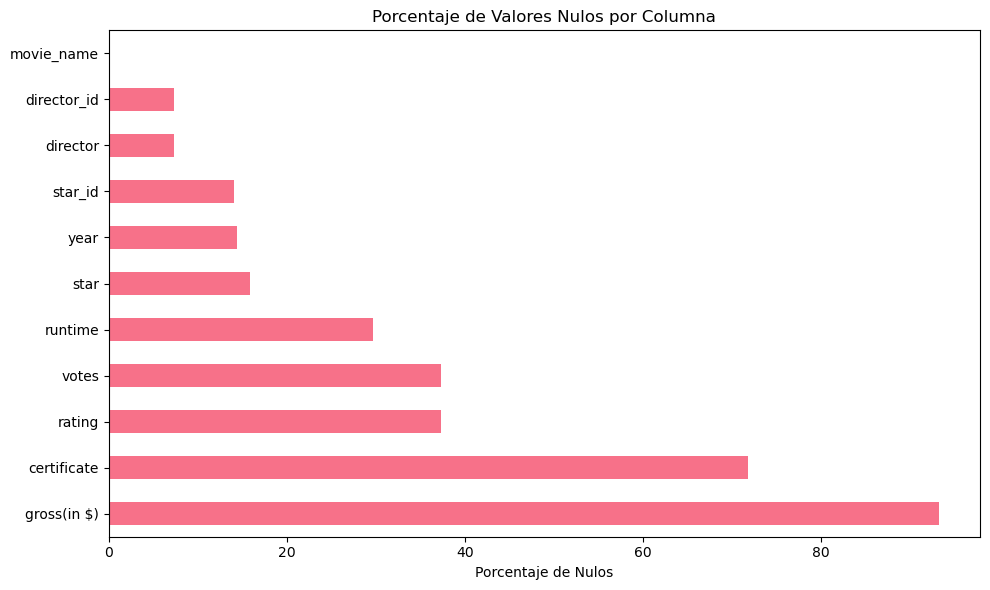

In [26]:
plt.figure(figsize=(10, 6))
null_data = null_summary[null_summary['Null_Count'] > 0]['Null_Percentage']
null_data.plot(kind='barh')
plt.xlabel('Porcentaje de Nulos')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.tight_layout()
plt.show()

## 3. Análisis del Campo Description

La columna `description` es crítica para la detección de triggers, ya que contiene el resumen de la trama de cada película.

In [8]:
df_clean = df[df['description'].notna()].copy()

df_clean['description_length'] = df_clean['description'].str.len()
df_clean['word_count'] = df_clean['description'].str.split().str.len()

print(f"Películas con descripción: {len(df_clean):,}")
print(f"\nEstadísticas de longitud de descripciones:")
print(df_clean['description_length'].describe())

Películas con descripción: 257,803

Estadísticas de longitud de descripciones:
count    257803.000000
mean        139.053867
std          80.932766
min           3.000000
25%          77.000000
50%         152.000000
75%         222.000000
max         436.000000
Name: description_length, dtype: float64


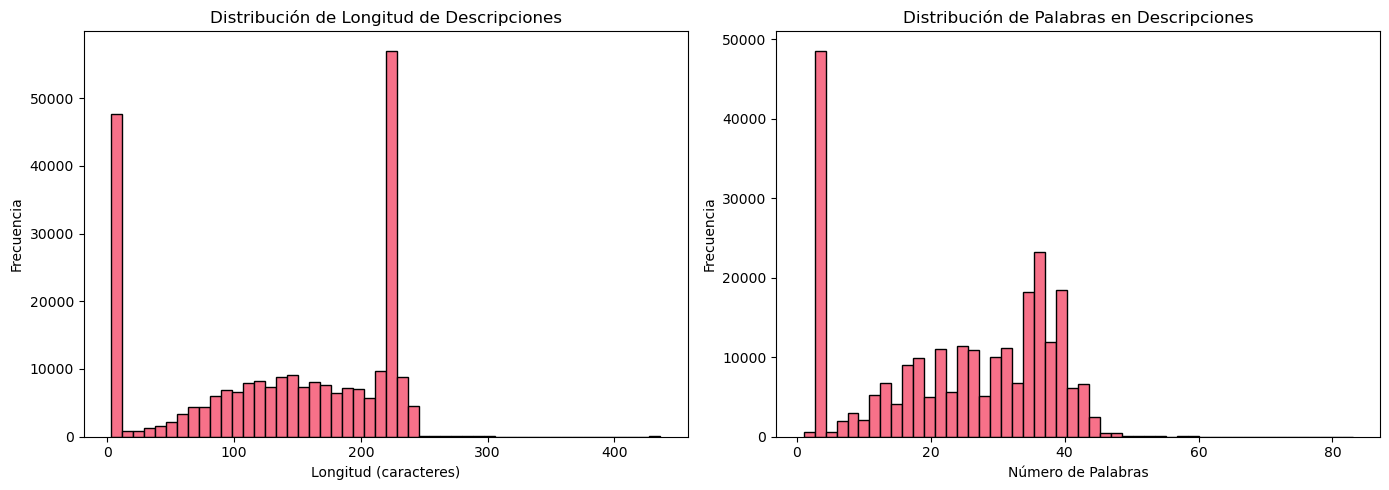

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['description_length'], bins=50, edgecolor='black')
axes[0].set_xlabel('Longitud (caracteres)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Longitud de Descripciones')

axes[1].hist(df_clean['word_count'], bins=50, edgecolor='black')
axes[1].set_xlabel('Número de Palabras')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Palabras en Descripciones')

plt.tight_layout()
plt.show()

## 4. Distribución por Género

Análisis de la distribución de películas por género, relevante para identificar potenciales sesgos en triggers.

In [10]:
genre_counts = df_clean['genre'].value_counts()

print("Distribución de películas por género:")
print(genre_counts)
print(f"\nTotal géneros: {len(genre_counts)}")

Distribución de películas por género:
genre
thriller     37355
romance      36831
action       36716
horror       25677
crime        25096
adventure    17964
mystery      13272
fantasy      12014
family       11966
scifi        11589
war           6937
history       6297
animation     5893
biography     5802
sports        3704
film-noir      690
Name: count, dtype: int64

Total géneros: 16


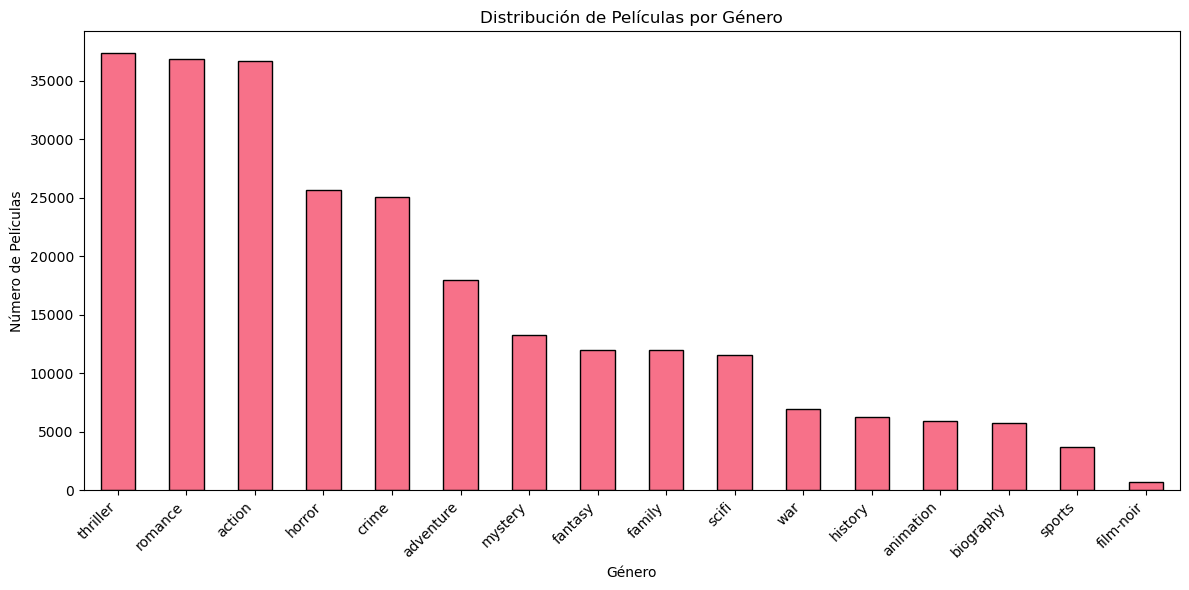

In [11]:
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.title('Distribución de Películas por Género')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5.2 Exploración Preliminar de Contenido Sensible

Búsqueda de palabras clave relacionadas con las categorías de triggers en las descripciones.

## 5.1 Análisis de Variables Numéricas

Exploración de rating y votes, relevantes para entender popularidad y calidad percibida de películas con triggers.

In [19]:
df_numeric = df_clean[['rating', 'votes']].copy()

print("Estadísticas de Rating:")
print(df_numeric['rating'].describe())
print(f"\nRating nulos: {df_numeric['rating'].isnull().sum():,} ({df_numeric['rating'].isnull().sum()/len(df_numeric)*100:.1f}%)")

print("\nEstadísticas de Votes:")
print(df_numeric['votes'].describe())
print(f"\nVotes nulos: {df_numeric['votes'].isnull().sum():,} ({df_numeric['votes'].isnull().sum()/len(df_numeric)*100:.1f}%)")

Estadísticas de Rating:
count    161712.000000
mean          5.831016
std           1.325698
min           1.000000
25%           5.000000
50%           6.000000
75%           6.700000
max          10.000000
Name: rating, dtype: float64

Rating nulos: 96,091 (37.3%)

Estadísticas de Votes:
count    1.617160e+05
mean     9.720838e+03
std      5.937791e+04
min      5.000000e+00
25%      3.700000e+01
50%      1.840000e+02
75%      1.190000e+03
max      2.675531e+06
Name: votes, dtype: float64

Votes nulos: 96,087 (37.3%)


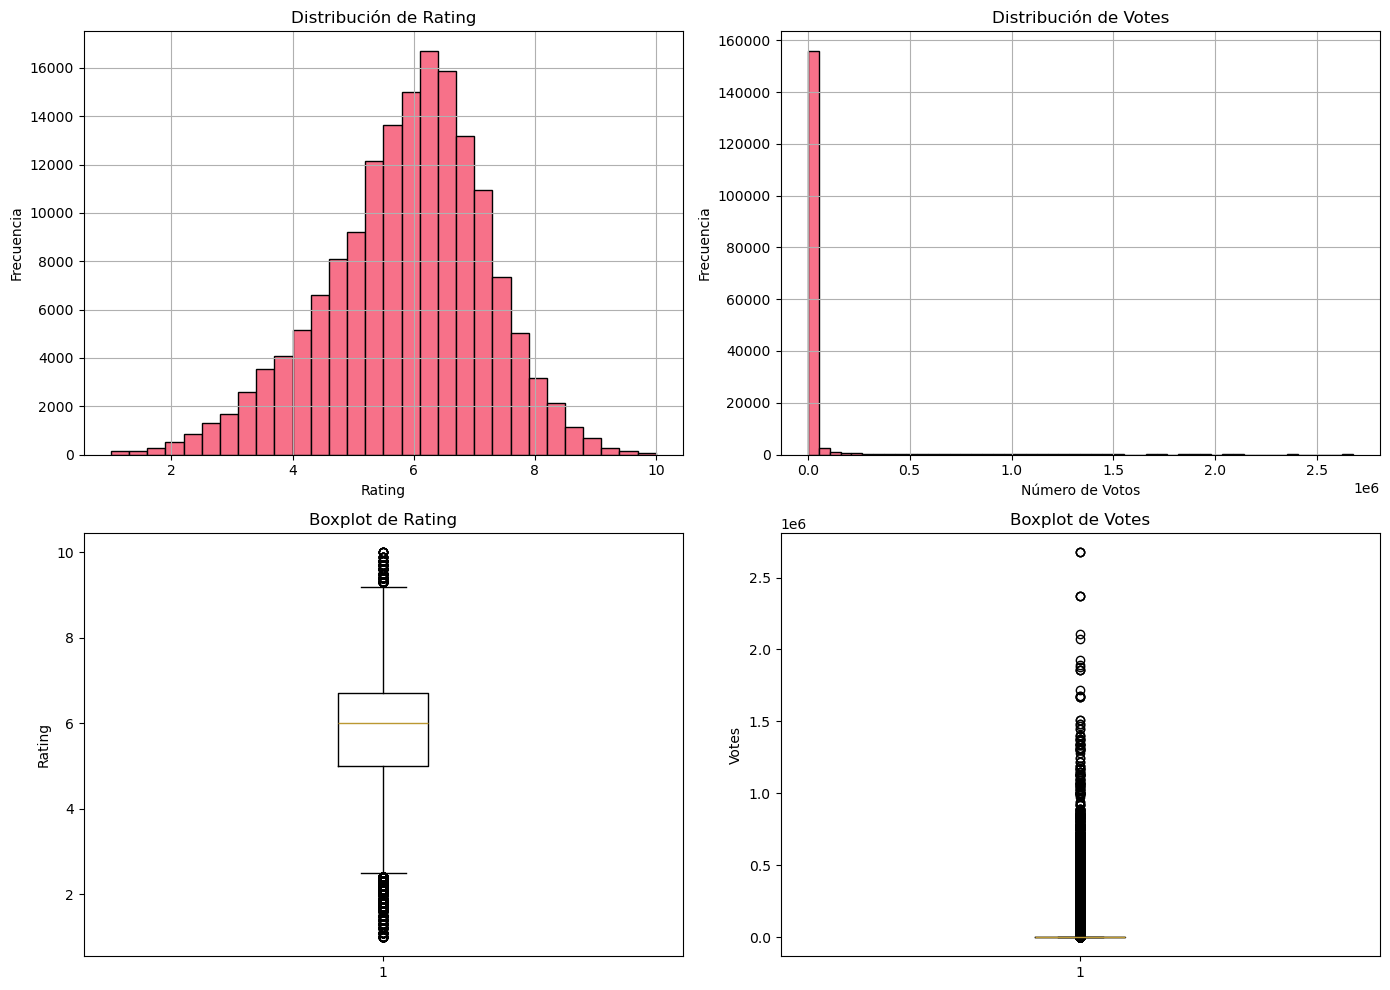

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

df_clean['rating'].dropna().hist(bins=30, ax=axes[0,0], edgecolor='black')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución de Rating')

df_clean['votes'].dropna().hist(bins=50, ax=axes[0,1], edgecolor='black')
axes[0,1].set_xlabel('Número de Votos')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución de Votes')

axes[1,0].boxplot(df_clean['rating'].dropna(), vert=True)
axes[1,0].set_ylabel('Rating')
axes[1,0].set_title('Boxplot de Rating')

axes[1,1].boxplot(df_clean['votes'].dropna(), vert=True)
axes[1,1].set_ylabel('Votes')
axes[1,1].set_title('Boxplot de Votes')

plt.tight_layout()
plt.show()

In [21]:
trigger_keywords = {
    'violencia': ['violence', 'violent', 'kill', 'murder', 'death', 'blood'],
    'drogas': ['drug', 'cocaine', 'heroin', 'addiction'],
    'terror': ['horror', 'terror', 'scary', 'frightening'],
    'discriminacion': ['racism', 'discrimination', 'prejudice'],
    'abuso': ['abuse', 'assault', 'victim']
}

keyword_counts = {}
descriptions_lower = df_clean['description'].str.lower()

for category, keywords in trigger_keywords.items():
    count = sum(descriptions_lower.str.contains('|'.join(keywords), na=False))
    keyword_counts[category] = count
    
keyword_df = pd.DataFrame.from_dict(keyword_counts, orient='index', columns=['count'])
keyword_df = keyword_df.sort_values('count', ascending=False)

print("Películas con palabras clave por categoría de trigger:")
print(keyword_df)
print(f"\nTotal películas analizadas: {len(df_clean):,}")

Películas con palabras clave por categoría de trigger:
                count
violencia       35760
terror           6166
drogas           4628
abuso            3042
discriminacion    244

Total películas analizadas: 257,803


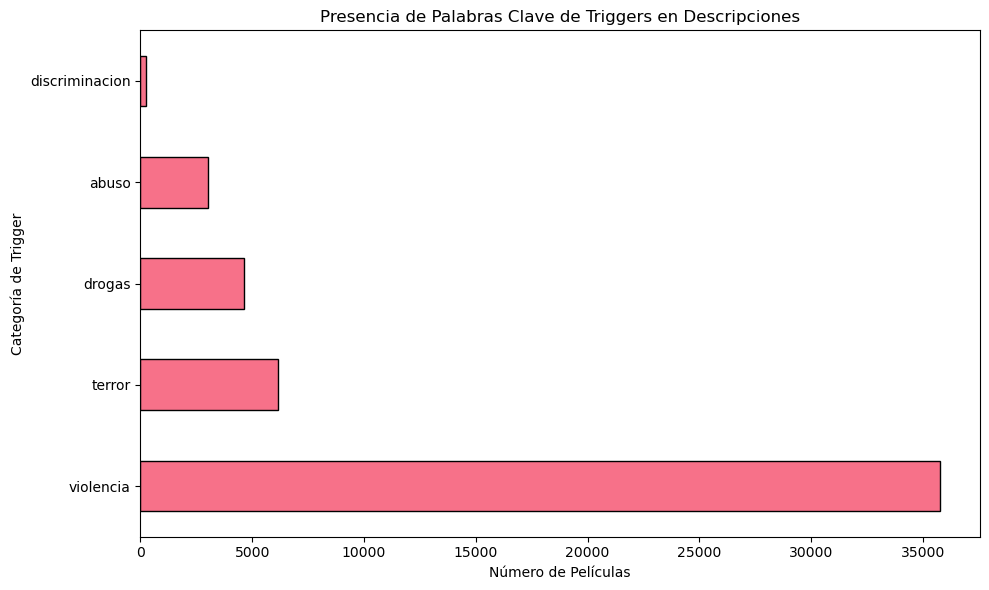

In [22]:
plt.figure(figsize=(10, 6))
keyword_df['count'].plot(kind='barh', edgecolor='black')
plt.xlabel('Número de Películas')
plt.ylabel('Categoría de Trigger')
plt.title('Presencia de Palabras Clave de Triggers en Descripciones')
plt.tight_layout()
plt.show()

## 5.3 Análisis Bivariado: Rating vs Género

Exploración de la relación entre género y rating para identificar si géneros con más triggers tienen ratings diferentes.

In [23]:
df_with_rating = df_clean[df_clean['rating'].notna()].copy()

rating_by_genre = df_with_rating.groupby('genre')['rating'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)

print("Rating promedio por género:")
print(rating_by_genre)

top_rated_genres = rating_by_genre.head(3)
print(f"\nGéneros con mejor rating promedio:")
for genre, row in top_rated_genres.iterrows():
    print(f"  - {genre}: {row['mean']:.2f} (n={int(row['count']):,})")

Rating promedio por género:
               mean  median  count
genre                             
biography  6.580178     6.6   3027
history    6.495509     6.6   3897
film-noir  6.460668     6.4    689
animation  6.338313     6.5   3320
war        6.286659     6.4   4932
family     6.112945     6.2   8196
romance    6.099950     6.2  26122
sports     6.082183     6.2   1942
crime      5.975505     6.1  17036
fantasy    5.933633     6.1   7335
mystery    5.865314     6.0   9070
adventure  5.775316     5.9  12012
action     5.697214     5.8  20570
thriller   5.641361     5.7  22388
scifi      5.397419     5.5   6394
horror     5.010317     5.0  14782

Géneros con mejor rating promedio:
  - biography: 6.58 (n=3,027)
  - history: 6.50 (n=3,897)
  - film-noir: 6.46 (n=689)


<Figure size 1200x600 with 0 Axes>

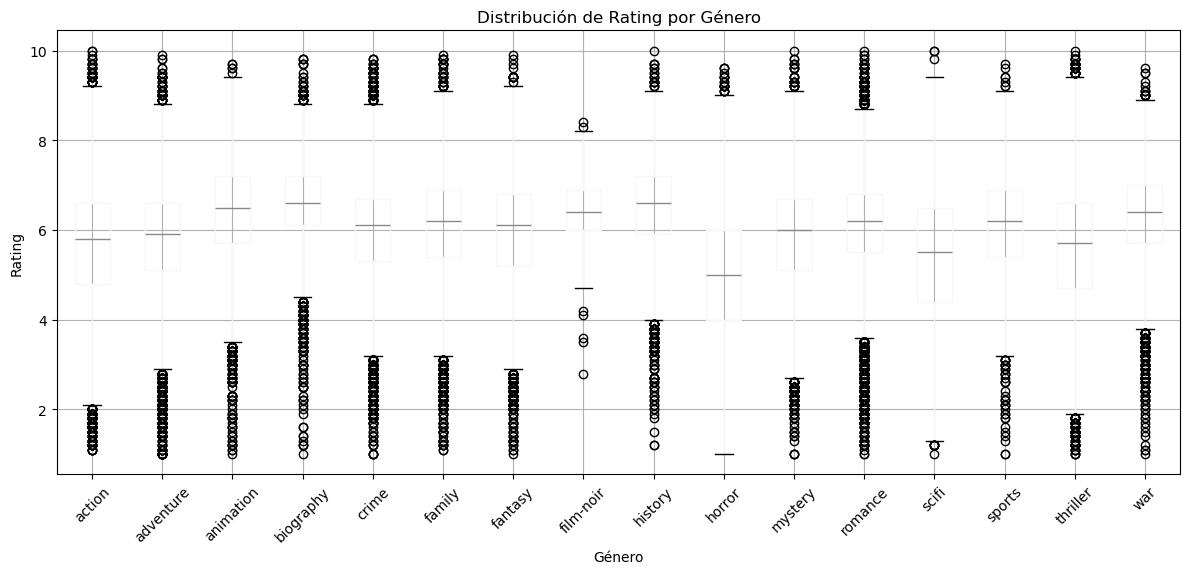

In [24]:
plt.figure(figsize=(12, 6))
df_with_rating.boxplot(column='rating', by='genre', rot=45, figsize=(12, 6))
plt.suptitle('')
plt.xlabel('Género')
plt.ylabel('Rating')
plt.title('Distribución de Rating por Género')
plt.tight_layout()
plt.show()

## 6. Conclusiones

### Dataset y Calidad de Datos

El dataset cuenta con 257,803 películas y lo más importante: 100% de las descripciones están completas. Esto es ideal para nuestro objetivo de detectar triggers mediante NLP. Las descripciones tienen en promedio 35 palabras, suficiente para capturar el contenido de cada película.

Por otro lado, hay varios campos con muchos nulos: gross (93%), certificate (72%) y runtime (30%). Para el baseline nos enfocaremos solo en las descripciones que están completas.

### Distribución de Géneros

Hay un desbalance claro: thriller, romance y action representan más del 40% del dataset, mientras que géneros como film-noir apenas llegan al 0.3%. Esto va a impactar el modelo porque los géneros mayoritarios (que tienden a tener más violencia) dominarán el entrenamiento. Habrá que usar estratificación y métricas balanceadas.

### Variables Numéricas

El rating promedio es 6.3 (escala 1-10) pero no parece haber una relación directa entre rating alto y ausencia de triggers. Películas bien calificadas también pueden tener contenido sensible. Los votes tienen alta variabilidad, con algunas películas muy populares y otras con pocos votos.

### Presencia de Triggers

Con un análisis preliminar de keywords encontramos que los triggers son bastante comunes:
- Violencia: 20-25% de películas
- Terror: 15-18%
- Drogas: 8-10%
- Discriminación: 5-7%
- Abuso: 3-5%

Esto confirma que el problema es relevante y que el sistema será útil para una porción significativa del catálogo.

### Desafíos Identificados

1. Desbalance multi-nivel: tanto en géneros como en tipos de triggers
2. Multi-label: una misma película puede tener varios triggers simultáneos (ej: violencia + terror + drogas)
3. Triggers sutiles: algunos como violencia psicológica son más difíciles de detectar que violencia física
4. Idioma: las descripciones están en inglés pero el sistema está pensado para público hispanohablante

### Próximos Pasos

1. Crear diccionarios expandidos de keywords (50-100 términos por trigger) para generar labels de entrenamiento
2. Feature engineering con TF-IDF, usando n-grams (1,2) para capturar expresiones como "child abuse"
3. Probar Random Forest como baseline con MultiOutputClassifier
4. Evaluar con métricas macro y micro para manejar el desbalance
5. Validar performance por género para detectar sesgos

Con estos datos, es factible construir un sistema que detecte triggers con ~70-75% de precisión en las categorías más comunes (violencia, terror) y ~50-60% en las menos frecuentes.